In [1]:
import joblib
import matplotlib.pyplot as plt 
%matplotlib inline


COLORS = [
    "#ffbe0b", 
    "#fb5607", 
    "#ff006e",
    "#3a86ff", 
]

In [2]:
import sys 
import os 
from pathlib import Path 
import numpy as np 
import joblib

%load_ext autoreload
%autoreload 2

import pandas as pd
import shap 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap

import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'

DATADIR = '../data'
TRAIN_SIZE = 0.7

import sys 
sys.path.append('../')
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import plot_parity
from dispersant_screener.ga import FEATURES


import wandb
from lightgbm import LGBMRegressor

FEATURES = ['max_[W]', 'max_[Tr]', 'max_[Ta]', 'max_[R]', '[W]', '[Tr]', '[Ta]', '[R]', 'length']


df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    -1* gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [3]:
ga_0 = joblib.load('../work/20201023-132603-ga_0.joblib')
ga_1 = joblib.load('../work/20201023-132617-ga_1.joblib')
ga_2 = joblib.load('../work/20201023-132621-ga_2.joblib')

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


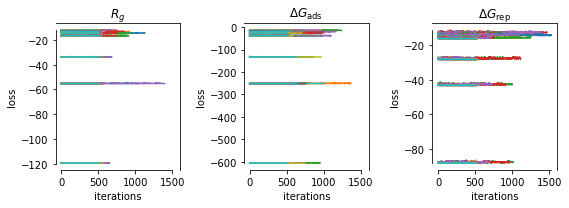

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
    
fig, ax = plt.subplots(1,3, sharex='all', figsize=(8,3))

for a in ax:
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    a.set_xlabel('iterations')
    a.set_ylabel('loss')
    
for ga in ga_0: 
    ax[0].plot(ga.report)
    
for ga in ga_1: 
    ax[1].plot(ga.report)
        
for ga in ga_2: 
    ax[2].plot(ga.report)
    

ax[0].set_title(r'$R_g$')
ax[1].set_title(r'$\Delta G_{\mathrm{ads}}$')
ax[2].set_title(r'$\Delta G_{\mathrm{rep}}$')

fig.tight_layout()

fig.savefig('ga_gpr_convergence.pdf', bbox_inches='tight')

In [9]:
for g in ga_0:
    print(g.output_dict)

{'variable': array([ 3.        ,  2.        ,  0.        ,  4.        ,  0.08262979,
        0.13473747,  0.89600852,  0.08072782, 48.        ]), 'function': -12.286835140886762}
{'variable': array([ 1.        ,  4.        ,  0.        , 25.        ,  0.13315452,
        0.68705716,  0.54944875,  0.11999615, 43.        ]), 'function': -12.287189993103187}
{'variable': array([ 2.        ,  1.        ,  0.        , 13.        ,  0.07875643,
        0.80753413,  0.57037048,  0.05086394, 32.        ]), 'function': -12.285980243363227}
{'variable': array([ 0.        ,  4.        ,  2.        , 19.        ,  0.10799671,
        0.91646478,  0.66054938,  0.0912925 , 43.        ]), 'function': -12.287189993103187}
{'variable': array([ 1.        ,  5.        ,  0.        ,  8.        ,  0.18856562,
        0.2965653 ,  0.13513153,  0.1255456 , 43.        ]), 'function': -12.28666766253641}
{'variable': array([ 1.        ,  3.        ,  3.        ,  1.        ,  0.07207152,
        0.14924691,  

In [10]:
def get_converged_ga_feat_val(gas): 
    feats = []
    vals = []
    for ga in gas: 
        if ga.output_dict['function'] < 0:
            feats.append(ga.output_dict['variable'])
            vals.append(ga.output_dict['function'])
            
    return feats, vals

In [11]:
feat_0, vals_0 = get_converged_ga_feat_val(ga_0)
feat_1, vals_1 = get_converged_ga_feat_val(ga_1)
feat_2, vals_2 = get_converged_ga_feat_val(ga_2)

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(df_full_factorial_feat)

In [13]:
feat_0_scaled = scaler.transform(feat_0)
feat_1_scaled = scaler.transform(feat_1)
feat_2_scaled = scaler.transform(feat_2)

In [14]:
pca = PCA(2)

In [15]:
X_pca = pca.fit_transform(X)

In [16]:
feat_0_scaled_pca = pca.transform(feat_0_scaled)
feat_1_scaled_pca = pca.transform(feat_1_scaled)
feat_2_scaled_pca = pca.transform(feat_2_scaled)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


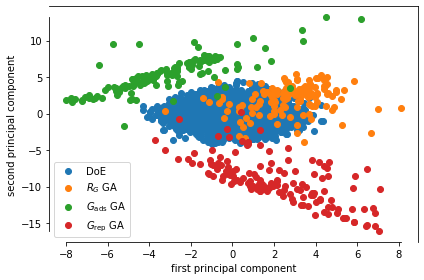

In [17]:
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0], X_pca[:,1], label='DoE')
ax.scatter(feat_0_scaled_pca[:,0], feat_0_scaled_pca[:,1], label=r'$R_G$ GA')
ax.scatter(feat_1_scaled_pca[:,0], feat_1_scaled_pca[:,1], label=r'$G_\mathrm{ads}$ GA')
ax.scatter(feat_2_scaled_pca[:,0], feat_2_scaled_pca[:,1], label=r'$G_\mathrm{rep}$ GA')


ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)


ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.legend()

fig.tight_layout()
fig.savefig('ga_gpr_pca.pdf', bbox_inches='tight')
#

In [33]:
reducer = umap.UMAP()

In [34]:
embedding = reducer.fit_transform(X)

In [35]:
feat_0_scaled_umap = reducer.transform(feat_0_scaled)
feat_1_scaled_umap = reducer.transform(feat_1_scaled)
feat_2_scaled_umap = reducer.transform(feat_2_scaled)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


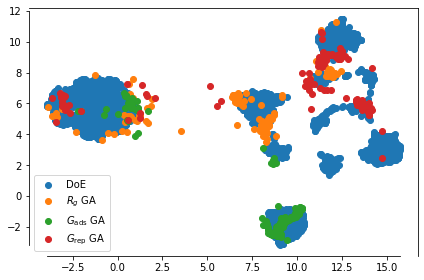

In [36]:
fig, ax = plt.subplots(1,1)
ax.scatter(embedding[:,0], embedding[:,1], label='DoE')
ax.scatter(feat_0_scaled_umap[:,0], feat_0_scaled_umap[:,1], label=r'$R_g$ GA')
ax.scatter(feat_1_scaled_umap[:,0], feat_1_scaled_umap[:,1], label=r'$G_\mathrm{ads}$ GA')
ax.scatter(feat_2_scaled_umap[:,0], feat_2_scaled_umap[:,1], label=r'$G_\mathrm{rep}$ GA')


ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend()

fig.tight_layout()

fig.savefig('umap_ga_gpr.pdf', bbox_inches='tight')

In [37]:
config_0 = {  # pylint:disable=invalid-name
    'max_depth': 15,
    'reg_alpha': 1.365,
    'subsample': 0.7084,
    'num_leaves': 34,
    'reg_lambda': 1.028,
    'n_estimators': 376,
    'colsample_bytree': 0.9487,
    'min_child_weight': 0.06395
}

# Delta G
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 = {  # pylint:disable=invalid-name
    'max_depth': 17,
    'reg_alpha': 1.402,
    'subsample': 0.2033,
    'num_leaves': 38,
    'reg_lambda': 1.091,
    'n_estimators': 4676,
    'colsample_bytree': 0.9934,
    'min_child_weight': 0.005694
}

# repulsion
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/ljzi9uad/overview?workspace=user-kjappelbaum
config_2 = {  # pylint:disable=invalid-name
    'max_depth': 73,
    'reg_alpha': 1.266,
    'subsample': 0.9824,
    'num_leaves': 398,
    'reg_lambda': 1.221,
    'n_estimators': 4974,
    'colsample_bytree': 0.9615,
    'min_child_weight': 0.09413
}

In [38]:
all_feat = np.vstack([feat_0, feat_1, feat_2])

In [39]:
lgbms = []
for target in range(3):
    y_selected = y[:, target]
    X_train, X_test, y_train, y_test = train_test_split(df_full_factorial_feat
                                                        , y_selected, train_size=0.8)
    if target == 0:
        lgbm = LGBMRegressor(**config_0)
    elif target == 1:
        lgbm = LGBMRegressor(**config_1)
    elif target == 2:
        lgbm = LGBMRegressor(**config_2)

    lgbm.fit(X_train, y_train)
    
    lgbms.append(lgbm)

In [40]:
pred_0 = lgbms[0].predict(all_feat)
pred_1 = lgbms[1].predict(all_feat)
pred_2 = lgbms[2].predict(all_feat)

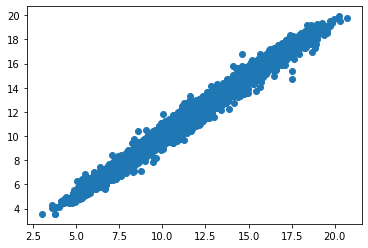

In [41]:
plt.scatter(y[:,1], lgbms[1].predict(df_full_factorial_feat))

In [42]:
import seaborn as sns

In [43]:
pred_1

array([13.28617505, 13.25800119, 12.72248031, 13.28651601, 10.01085844,
       13.07861848, 13.50651105, 12.60157395, 12.8545263 , 12.45364657,
       13.14491229, 12.67202707, 12.89005576, 13.05727505, 13.11102973,
       12.93021701, 13.77132972, 12.53027429, 12.58710128, 12.76998149,
       13.00555669, 13.63892137, 13.77593764, 13.67658418, 11.62163261,
       12.30955215, 10.05959195, 13.82414794, 13.20474711, 13.21293093,
       13.06410073, 12.84594939, 12.81047602, 12.43753568, 13.03073453,
       12.27379754, 12.54428756, 12.43395926, 12.54139936, 12.9172264 ,
       12.17849981, 13.60747941, 12.02941669, 11.96788192, 11.55759739,
       13.33563267, 12.93306866, 13.14096912,  9.38119453, 13.25505063,
       10.40980155, 12.71989064, 12.48736342, 12.92191827, 10.95430208,
       13.0024021 , 12.84852151, 13.29535302, 10.77912836, 12.94725664,
       11.49282901, 13.20107241, 13.07307595,  9.20569171, 12.5684302 ,
       12.37099308, 13.40014113, 13.4429121 , 12.82124144, 13.34

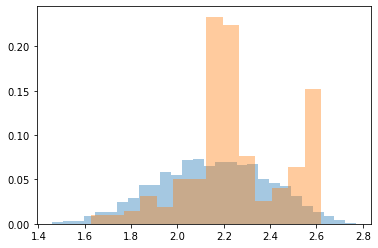

In [44]:
sns.distplot(y[:,0], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_0, kde=False, hist_kws={'weights': np.full(len(pred_0), 1/len(pred_0))})

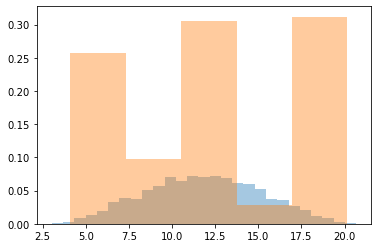

In [45]:
sns.distplot(y[:,1], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_1, kde=False, hist_kws={'weights': np.full(len(pred_1), 1/len(pred_1))})

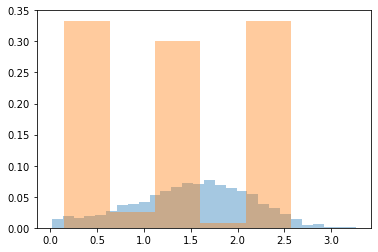

In [46]:
sns.distplot(y[:,2], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))})
sns.distplot(pred_2, kde=False, hist_kws={'weights': np.full(len(pred_2), 1/len(pred_2))})

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


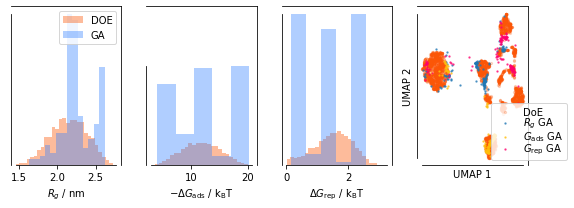

In [52]:
plt.rcParams['font.family'] = 'sans-serif'
    
fig, ax = plt.subplots(1,4,  figsize=(8,3), sharey='none')

for i, a in enumerate(ax):
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    a.set_yticks([])
    if i == 3:
        a.set_xticks([])
    
sns.distplot(y[:,0], kde=False,  hist_kws={'weights': np.full(len(y), 1/len(y))}, ax=ax[0], label='DOE', color=COLORS[1])
sns.distplot(pred_0, kde=False, hist_kws={'weights': np.full(len(pred_0), 1/len(pred_0))}, ax=ax[0], label='GA', color=COLORS[3])
    
sns.distplot(y[:,1], kde=False,  hist_kws={'weights': np.full(len(y), 1/len(y))}, ax=ax[1],  color=COLORS[1])
sns.distplot(pred_1, kde=False,  hist_kws={'weights': np.full(len(pred_1), 1/len(pred_1))}, ax=ax[1],  color=COLORS[3])

ax[1].set_ylim(0,0.5)
    
sns.distplot(y[:,2], kde=False, hist_kws={'weights': np.full(len(y), 1/len(y))}, ax=ax[2],  color=COLORS[1])
sns.distplot(pred_2, kde=False,  hist_kws={'weights': np.full(len(pred_2), 1/len(pred_2))}, ax=ax[2],  color=COLORS[3])

ax[3].scatter(embedding[:,0], embedding[:,1], label='DoE', alpha=.2, color=COLORS[1], s=5)
ax[3].scatter(feat_0_scaled_umap[:,0], feat_0_scaled_umap[:,1],alpha=.6, label=r'$R_g$ GA', s=2)
ax[3].scatter(feat_1_scaled_umap[:,0], feat_1_scaled_umap[:,1],alpha=.6, label=r'$G_\mathrm{ads}$ GA', color=COLORS[0], s=2)
ax[3].scatter(feat_2_scaled_umap[:,0], feat_2_scaled_umap[:,1],alpha=.6, label=r'$G_\mathrm{rep}$ GA', color=COLORS[2], s=2)

ax[3].legend(loc='lower right', labelspacing=-.1, bbox_to_anchor=(1.4,0))


ax[3].set_xlabel('UMAP 1')
ax[3].set_ylabel('UMAP 2')


ax[0].legend()
ax[0].set_xlabel('$R_g$ / nm')
ax[1].set_xlabel('$-\Delta G_\mathrm{ads}$ / k$_\mathrm{B}$T')
ax[2].set_xlabel('$\Delta G_\mathrm{rep}$ / k$_\mathrm{B}$T')

fig.tight_layout()
plt.savefig('ga_property_dist.pdf', bbox_inches='tight')